In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
# import libraries

import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
# Read the Final Dataset
df = pd.read_csv(r'/content/drive/MyDrive/Colab_Work/Pytorch/NLP Assignment/final_preprocessed_data.csv')
df.head()

,text,category
0,long covid community open growing community pe...,1
1,government test prep platform adda october sai...,5
2,private equity venture capital investment diwa...,2
3,digital book keeping startup khatabook said au...,5
4,event always important exciting organize kind ...,6


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4069 entries, 0 to 4068
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      4069 non-null   object
 1   category  4069 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 63.7+ KB


In [50]:
df.category.value_counts()

1    600
5    600
2    600
4    600
3    600
0    600
6    469
Name: category, dtype: int64

In [51]:
df.columns

Index(['text', 'category'], dtype='object')

In [52]:
# define the lstm model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=dropout, batch_first=True) # lstm layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # fully connected layer
        self.dropout = nn.Dropout(dropout) # dropout layer

    def forward(self, text):
        embedded = self.embedding(text) # embedded = [batch size, sent len, emb dim]
        output, (hidden, cell) = self.lstm(embedded) # output = [batch size, sent len, hid dim * num directions]
        hidden = self.dropout(
            torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)) # hidden = [batch size, hid dim * num directions]
        return self.fc(hidden.squeeze(0))


In [1]:
from tensorflow.keras.utils import pad_sequences


In [53]:
# perform padding for lstm model

# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import pad_sequences

# max length of text
max_length = max([len(i) for i in df.text])
print(max_length)

# tokenize the text
tokenizer = Tokenizer() # create a tokenizer
tokenizer.fit_on_texts(df.text) # fit the tokenizer on the documents
sequences = tokenizer.texts_to_sequences(df.text) # convert text to a sequence of tokens
padded = pad_sequences(sequences, maxlen=max_length,
                       padding='post', truncating='post') # pad the sequences
print(padded.shape)


2000
(4069, 2000)


In [54]:
# split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(
    padded, df.category, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(3255, 2000)
(814, 2000)
(3255,)
(814,)


In [55]:
train_data = TensorDataset(torch.from_numpy(
    X_train), torch.from_numpy(y_train.values)) # create Tensor datasets
test_data = TensorDataset(torch.from_numpy(
    X_test), torch.from_numpy(y_test.values)) # create Tensor datasets

batch_size = 64

trainloader = DataLoader(train_data, shuffle=True, batch_size=batch_size) 
testloader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


In [56]:
# define the hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100 
hidden_dim = 256
output_dim = 7
n_layers = 2
bidirectional = True
dropout = 0.5

# define the model
model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
print(model)

LSTM(
  (embedding): Embedding(27071, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [57]:
def train(model, device, trainloader, optimizer, criterion):

    #  function to train the model (forward, backward, update)

    model.train() # sets the mode of the PyTorch neural network model to training mode.
    train_loss = 0

    for inputs, labels in trainloader: #* Iterate through the train_loader to get the images and labels
        inputs = inputs.to(device) 
        labels = labels.to(device) #* Move labels to the device (GPU or CPU)

        optimizer.zero_grad() #* Clear gradients w.r.t. parameters

        outputs = model(inputs) #* Forward pass 

        loss = criterion(outputs, labels) #* Calculate Loss
        loss.backward() #* Getting gradients w.r.t. parameters (Backpropagation) #  computes the gradients of the loss function with respect to the model parameters

        optimizer.step() #* Updating parameters
        train_loss += loss.item() * inputs.size(0) #* Update training loss

    return train_loss / len(trainloader) #* Return average training loss

def test(model, device, testloader, criterion): 

    # function to test the model
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad(): 
        for inputs, labels in testloader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs) #! Forward pass
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item() #! Total correct predictions

    return test_loss / len(testloader), correct / len(testloader.dataset) #! Return average test loss and accuracy


In [58]:
# hyperparameters
num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss() #* Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #* Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTM(
  (embedding): Embedding(27071, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [60]:
train_losses = []
test_losses = []
test_accs = []

for epoch in tqdm(range(num_epochs)): 

    train_loss = train(model, device, trainloader, optimizer, criterion)
    test_loss, test_acc = test(model, device, testloader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

 10%|█         | 1/10 [00:38<05:49, 38.84s/it]

Epoch [1/10], Train Loss: 103.0135, Test Loss: 77.8412, Test Accuracy: 0.4963


 20%|██        | 2/10 [01:18<05:13, 39.24s/it]

Epoch [2/10], Train Loss: 66.8395, Test Loss: 58.5985, Test Accuracy: 0.6708


 30%|███       | 3/10 [01:59<04:39, 39.97s/it]

Epoch [3/10], Train Loss: 50.1622, Test Loss: 50.4078, Test Accuracy: 0.7174


 40%|████      | 4/10 [02:39<04:00, 40.14s/it]

Epoch [4/10], Train Loss: 38.7014, Test Loss: 48.2428, Test Accuracy: 0.7543


 50%|█████     | 5/10 [03:20<03:21, 40.24s/it]

Epoch [5/10], Train Loss: 31.8876, Test Loss: 48.3857, Test Accuracy: 0.7432


 60%|██████    | 6/10 [04:02<02:44, 41.04s/it]

Epoch [6/10], Train Loss: 23.0650, Test Loss: 49.3534, Test Accuracy: 0.7445


 70%|███████   | 7/10 [04:45<02:04, 41.48s/it]

Epoch [7/10], Train Loss: 17.4611, Test Loss: 48.4100, Test Accuracy: 0.7641


 80%|████████  | 8/10 [05:27<01:23, 41.95s/it]

Epoch [8/10], Train Loss: 12.2839, Test Loss: 50.4923, Test Accuracy: 0.7776


 90%|█████████ | 9/10 [06:09<00:41, 41.85s/it]

Epoch [9/10], Train Loss: 10.8214, Test Loss: 48.5352, Test Accuracy: 0.7862


100%|██████████| 10/10 [06:51<00:00, 41.11s/it]

Epoch [10/10], Train Loss: 7.2314, Test Loss: 52.5575, Test Accuracy: 0.7641


In [61]:
# test the model
test_loss, test_accuracy = test(model, device, testloader, criterion)


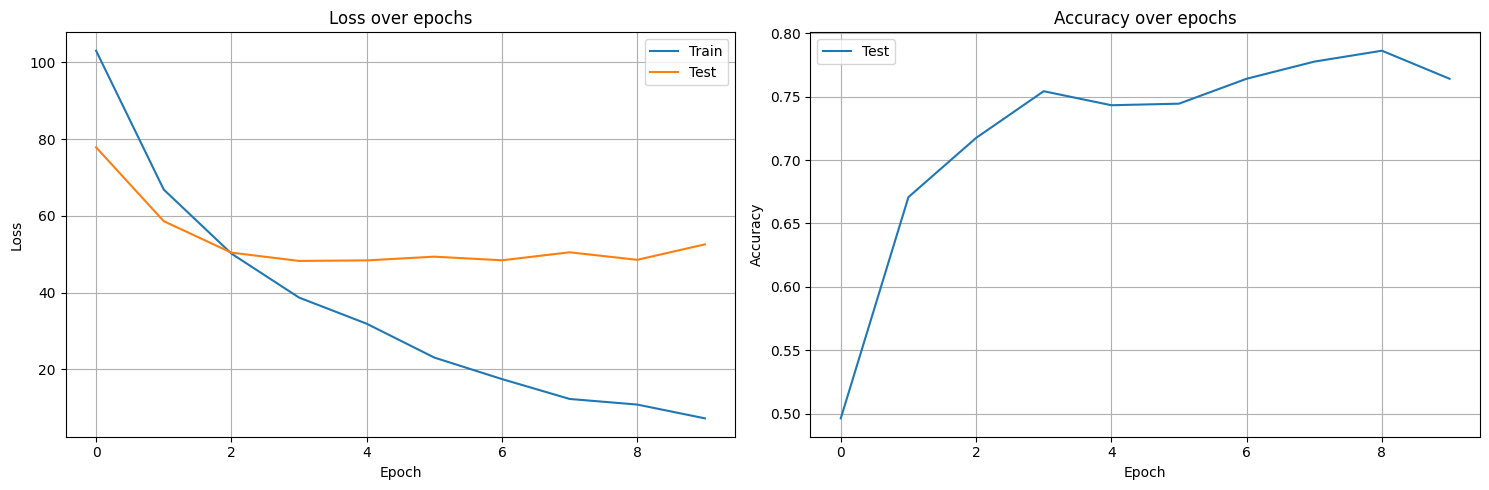

In [62]:
def visualize_results(train_losses, test_losses, test_accs): #^ function to visualize the results

    fig, axs = plt.subplots(1, 2, figsize=(15, 5)) #^ Create a figure and a set of subplots

    axs[0].plot(train_losses, label='Train') #^ Plot the train losses in the first subplot
    axs[0].plot(test_losses, label='Test') #^ Plot the test losses in the first subplot
    axs[0].set_title('Loss over epochs')

    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[0].grid(True)
    
    axs[1].plot(test_accs, label='Test') #^ Plot the test accuracies in the second subplot
    axs[1].set_title('Accuracy over epochs')
    axs[1].set_xlabel('Epoch')

    axs[1].set_ylabel('Accuracy')

    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout() 
    plt.show()

visualize_results(train_losses, test_losses, test_accs) #! Visualize the results

In [63]:
# save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab_Work/Pytorch/NLP Assignment/modelLSTM.pt')

# load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Work/Pytorch/NLP Assignment/modelLSTM.pt'))


<All keys matched successfully>

In [64]:
# predict the test data
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.17      0.16      0.16       129
           1       0.13      0.13      0.13       106
           2       0.21      0.19      0.20       134
           3       0.11      0.11      0.11       111
           4       0.20      0.19      0.19       108
           5       0.16      0.20      0.17       127
           6       0.19      0.17      0.18        99

    accuracy                           0.16       814
   macro avg       0.17      0.16      0.16       814
weighted avg       0.17      0.16      0.17       814



we can see that the overall accuracy of the model is 0.16, which is very low. The precision, recall, and F1-score for each category are also low, indicating that the model is not performing well in any of the categories. The macro and weighted average of the precision, recall, and F1-score are also low, indicating that the model is not performing well overall. 

Therefore, we need to improve the model by tweaking hyperparameters, increasing the size of the dataset, or using a different approach to classification.